<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [1]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow 2.x selected.
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6077 sha256=a9540cdee4e29ac7c02c98b6d58a1d4535300efcfdebc87d2c6d3070a5c2ed70
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
  Created wheel for fred: filename=fred-3.1-cp36-none-any.whl size=3911 sha256=b3a9713db5e7415fcac7733959a1b727737da332ea479d517bd771974ce61d6a
  Stored in directory: /root/.cache/pip/wheels/c5/4c/87/eb32bd051f3888ff21dbcd0cbc8a5512579aba99213e7d3183
Successfully built fred


Using TensorFlow backend.


# Data Preparation

In [0]:
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


## FOREX data

In [3]:
# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

# Normalise data
forex_mean = forexDataN.mean()
forex_std = forexDataN.std()
forexDataN = (forexDataN - forex_mean) / forex_std

dates = dataGbpEurRate.Date

forexData = {'Date':dataGbpEurRate.Date,'Value':forexDataN}

mainDf = pd.DataFrame(forexData)

print (mainDf)

           Date     Value
0    2001-01-02  1.638603
1    2001-01-03  1.714443
2    2001-01-04  1.650130
3    2001-01-05  1.591885
4    2001-01-08  1.632535
...         ...       ...
4821 2020-01-27 -0.747648
4822 2020-01-28 -0.779198
4823 2020-01-29 -0.768883
4824 2020-01-30 -0.738547
4825 2020-01-31 -0.722165

[4826 rows x 2 columns]


### FOREX feature engineering

In [0]:
ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

fiveDayMovingAverages = getMovingAverages(forexDataN, 5)
tenDayMovingAverages = getMovingAverages(forexDataN, 10)

fiveDayDict = {ukFOREXdates[i]: fiveDayMovingAverages[i] for i in range(len(fiveDayMovingAverages))}
tenDayDict = {ukFOREXdates[i]: tenDayMovingAverages[i] for i in range(len(tenDayMovingAverages))}

## Interest Rate Data (INT)


### INT data retreival

In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
def cleanDataSets(dataset):

    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    for index, row in mainDf.iterrows():
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        if(value==1000000):
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR1mC = cleanDataSets(GBR1mJson)
EUR1mC = cleanDataSets(EUR1mJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

In [0]:
def getDifferenceFeatures(xDict, yDict):
    dates = []
    valuesX = []
    valuesY = []
    ratioValues = []                      

    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    diffValues = datasetXarr - datasetYarr

    data_mean = diffValues.mean()
    data_std = diffValues.std()
    dataNormalised = (diffValues - data_mean) - data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

GBPEURovrRatio = getDifferenceFeatures(GBRovrC,EURovrC)
GBPEUR1mRatio = getDifferenceFeatures(GBR1mC,EUR1mC)
GBPEUR3mRatio = getDifferenceFeatures(GBR3mC,EUR3mC)
GBPEUR6mRatio = getDifferenceFeatures(GBR6mC,EUR6mC)
GBPEUR12mRatio = getDifferenceFeatures(GBR12mC,EUR12mC)

## Inflation data (CPI)

### CPI data retreival

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [9]:
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        roundD = row['Date'].replace(day=1)

        value= dataset.get(pd.Timestamp(roundD),1000000)

        if(value==1000000):
            clean = False
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    if(clean==True):
        print("Data is clean")

    return cleanedDataDict


ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [10]:
dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)

    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()

ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

print(cpiDict)

{Timestamp('2001-01-02 00:00:00'): -1.4457201262439292, Timestamp('2001-01-03 00:00:00'): -1.4457201262439292, Timestamp('2001-01-04 00:00:00'): -1.4457201262439292, Timestamp('2001-01-05 00:00:00'): -1.4457201262439292, Timestamp('2001-01-08 00:00:00'): -1.4457201262439292, Timestamp('2001-01-09 00:00:00'): -1.4457201262439292, Timestamp('2001-01-10 00:00:00'): -1.4457201262439292, Timestamp('2001-01-11 00:00:00'): -1.4457201262439292, Timestamp('2001-01-12 00:00:00'): -1.4457201262439292, Timestamp('2001-01-15 00:00:00'): -1.4457201262439292, Timestamp('2001-01-16 00:00:00'): -1.4457201262439292, Timestamp('2001-01-17 00:00:00'): -1.4457201262439292, Timestamp('2001-01-18 00:00:00'): -1.4457201262439292, Timestamp('2001-01-19 00:00:00'): -1.4457201262439292, Timestamp('2001-01-22 00:00:00'): -1.4457201262439292, Timestamp('2001-01-23 00:00:00'): -1.4457201262439292, Timestamp('2001-01-24 00:00:00'): -1.4457201262439292, Timestamp('2001-01-25 00:00:00'): -1.4457201262439292, Timestamp

## International Reserves data (IR)

### IR data retreival

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [12]:
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

In [13]:
IRdates = []
ukIRarr = []
euIRarr = []

for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)


ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)

ukEuIRRatio = ukIRarr / euIRarr

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)

print(irDict)

{Timestamp('2001-01-02 00:00:00'): 4.969333354250762, Timestamp('2001-01-03 00:00:00'): 4.969333354250762, Timestamp('2001-01-04 00:00:00'): 4.969333354250762, Timestamp('2001-01-05 00:00:00'): 4.969333354250762, Timestamp('2001-01-08 00:00:00'): 4.969333354250762, Timestamp('2001-01-09 00:00:00'): 4.969333354250762, Timestamp('2001-01-10 00:00:00'): 4.969333354250762, Timestamp('2001-01-11 00:00:00'): 4.969333354250762, Timestamp('2001-01-12 00:00:00'): 4.969333354250762, Timestamp('2001-01-15 00:00:00'): 4.969333354250762, Timestamp('2001-01-16 00:00:00'): 4.969333354250762, Timestamp('2001-01-17 00:00:00'): 4.969333354250762, Timestamp('2001-01-18 00:00:00'): 4.969333354250762, Timestamp('2001-01-19 00:00:00'): 4.969333354250762, Timestamp('2001-01-22 00:00:00'): 4.969333354250762, Timestamp('2001-01-23 00:00:00'): 4.969333354250762, Timestamp('2001-01-24 00:00:00'): 4.969333354250762, Timestamp('2001-01-25 00:00:00'): 4.969333354250762, Timestamp('2001-01-26 00:00:00'): 4.969333354


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [15]:
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        if(value==1000000):
            mainDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict


ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [16]:
BOPdates = []
ukBOParr = []
euBOParr = []

for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)

ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

print(bopDict)

{Timestamp('2001-01-02 00:00:00'): 0.29591469952372285, Timestamp('2001-01-03 00:00:00'): 0.29591469952372285, Timestamp('2001-01-04 00:00:00'): 0.29591469952372285, Timestamp('2001-01-05 00:00:00'): 0.29591469952372285, Timestamp('2001-01-08 00:00:00'): 0.29591469952372285, Timestamp('2001-01-09 00:00:00'): 0.29591469952372285, Timestamp('2001-01-10 00:00:00'): 0.29591469952372285, Timestamp('2001-01-11 00:00:00'): 0.29591469952372285, Timestamp('2001-01-12 00:00:00'): 0.29591469952372285, Timestamp('2001-01-15 00:00:00'): 0.29591469952372285, Timestamp('2001-01-16 00:00:00'): 0.29591469952372285, Timestamp('2001-01-17 00:00:00'): 0.29591469952372285, Timestamp('2001-01-18 00:00:00'): 0.29591469952372285, Timestamp('2001-01-19 00:00:00'): 0.29591469952372285, Timestamp('2001-01-22 00:00:00'): 0.29591469952372285, Timestamp('2001-01-23 00:00:00'): 0.29591469952372285, Timestamp('2001-01-24 00:00:00'): 0.29591469952372285, Timestamp('2001-01-25 00:00:00'): 0.29591469952372285, Timestamp

## Creating full data matrix

In [17]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

completeDf = pd.DataFrame(columns=['Date','ForexRate','5dayMovingAvg','10dayMovingAvg','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0
 
for index, row in mainDf.iterrows():

    date = row['Date']
    forex = row['Value']
    movingAvg5Day = fiveDayDict.get(date, 0)
    movingAvg10Day = tenDayDict.get(date, 0)
    
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)

    ovrI = GBPEURovrRatio.get(date, 0)
    i1month = GBPEUR1mRatio.get(date, 0)
    i3month = GBPEUR3mRatio.get(date, 0)
    i6month = GBPEUR6mRatio.get(date, 0)
    i12month = GBPEUR12mRatio.get(date, 0)

    completeDf = completeDf.append({'Date':date,
                            'ForexRate':forex,
                            '5dayMovingAvg':movingAvg5Day,
                            '10dayMovingAvg':movingAvg10Day,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '1mLIBOR': i1month,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)

print(completeDf)

           Date  ForexRate  5dayMovingAvg  10dayMovingAvg  CPIRatio   IRRatio  \
0    2001-01-02  1.638603   1.638603       1.638603       -1.445720  4.969333   
1    2001-01-03  1.714443   1.676523       1.676523       -1.445720  4.969333   
2    2001-01-04  1.650130   1.667726       1.667726       -1.445720  4.969333   
3    2001-01-05  1.591885   1.648765       1.648765       -1.445720  4.969333   
4    2001-01-08  1.632535   1.645519       1.645519       -1.445720  4.969333   
...         ...       ...        ...            ...             ...       ...   
4734 2019-09-24 -1.055864  -1.073823      -1.095059        0.563933  0.376361   
4735 2019-09-25 -1.087414  -1.072974      -1.090751        0.563933  0.376361   
4736 2019-09-26 -1.100155  -1.075522      -1.084926        0.563933  0.376361   
4737 2019-09-27 -1.118357  -1.088627      -1.084866        0.563933  0.376361   
4738 2019-09-30 -1.083167  -1.088992      -1.084380        0.563933  0.376361   

      BOPRatio  OvrLIBOR   

# Feature Importances

In [18]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# load data

filename = 'pima-indians-diabetes.data.csv'
names = ['Date','ForexRate','5dayMovingAvg','10dayMovingAvg','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR', '1mLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

#dataframe = read_csv(filename, names=names)


array = completeDf.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

TypeError: ignored

# Neural Networks

## Single-step LSTM

### Building network

In [0]:
EPOCHS = 10
EVALUATION_INTERVAL = 100
VALIDATION_STEPS = 50
TIME_LAGS = 30
PREDICTION_HORIZON = 10
STEP = 1
BATCH_SIZE = 30

features = ['ForexRate', 'CPIRatio', 'OvrLIBOR']

def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(TIME_LAGS, len(features))),
        layers.Dense(1)
    ])

    singleStepLSTMModel.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return singleStepLSTMModel


model = singleStepLSTM()

### Cross validation

In [63]:
def singleStepDataSplit(dataset, target, startIndex, endIndex, timeLags,
                target_size, step):
  
    data = []
    labels = []

    startIndex = startIndex + timeLags

    if endIndex is None:
        endIndex = len(dataset) - target_size

    for i in range(startIndex, endIndex):

        dataIndices = range(i-timeLags, i, step)
        data.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

dataSet = completeDf[features]
dataSet.index = mainDf['Date']
dataSet = dataSet.values

FOLDS = 6

steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

for x in range(0,len(dataSet), steps):
    fold_locations.append(x)
    
for x in range(1,FOLDS):

    valIndex = fold_locations[x]
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]


    xTrain, yTrain = singleStepDataSplit(dataSet, dataSet[:, 0], 0, valIndex, TIME_LAGS, PREDICTION_HORIZON, STEP)

    xVal, yVal = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, TIME_LAGS, PREDICTION_HORIZON, STEP)

    dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
    dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()

    dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
    dataVal = dataVal.batch(BATCH_SIZE).repeat()

    print("--------------------- Fold", "%d/%d --------------------------" % (x, FOLDS))

    result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=dataVal, validation_steps=50)
    
    results.append(result)


--------------------- Fold 1/6 --------------------------
Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 30ms/step - loss: 0.1036 - val_loss: 0.2233
Epoch 2/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0305 - val_loss: 0.1020
Epoch 3/10
100/100 [==============================] - 2s 15ms/step - loss: 0.0279 - val_loss: 0.0642
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0249 - val_loss: 0.1196
Epoch 5/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0243 - val_loss: 0.1330
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0224 - val_loss: 0.1552
Epoch 7/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0213 - val_loss: 0.0527
Epoch 8/10
100/100 [==============================] - 2s 16ms/step - loss: 0.0212 - val_loss: 0.0978
Epoch 9/10
100/100 [==============================] - 2s 15ms/step - loss: 0.0203 - val_los

### Prediction visualisation

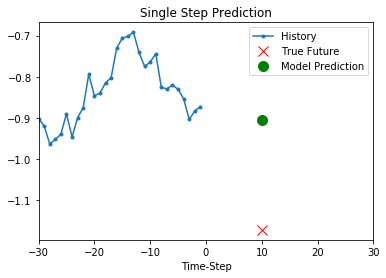

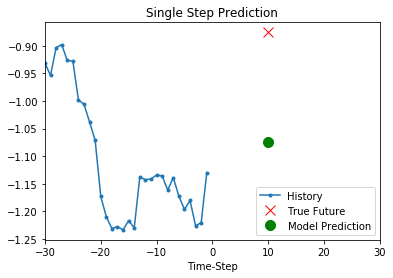

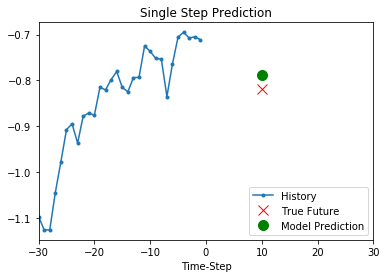

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0],1)
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


for x, y in dataVal.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                        model.predict(x)[0]], PREDICTION_HORIZON,
                    'Single Step Prediction')
    plot.show()

# Models

## Standard ANN

In [0]:
from joblib import dump, load
import pickle


def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(data[indices])
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)


TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)

print(xTest[0])
print(yTest[0])

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 10
EPOCHS = 2

def standard_ann_model():
	model = keras.Sequential([
        layers.Dense(6,input_dim=(6),kernel_initializer='normal',activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

	model.compile(optimizer='adam', loss='mse')
	return model


model = standard_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=dataVal,
                    validation_steps=50
          )


model.save('newmodel.h5')

result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)


#print(type(model))

## Univariate LSTM

In [0]:
def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(np.reshape(data[indices], (historySize, 1)))
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)

TRAIN_SPLIT = round(len(forexDataN) * 0.7)
VALIDATION_SPLIT = round(len(forexDataN) * 0.85)

xTrain, yTrain = formatData(forexDataN, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexDataN, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexDataN, VALIDATION_SPLIT, None, historySize, futureDistance)


BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 100
EPOCHS = 10

def lstm_ann_model_single():
    lstm_model = keras.Sequential([
        layers.LSTM(8, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

modelS = lstm_ann_model_single()

modelS.fit(dataTrain, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=dataVal,
                      validation_steps=50)



result = modelS.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)



## Multivariate LSTM (Single-step)

In [0]:
EPOCHS = 2
EVALUATION_INTERVAL = 10

features = ['ForexRate', 'CPIRatio', 'OvrLIBOR']

dataSet = mainDf[features]
dataSet.index = mainDf['Date']

dataSet = dataSet.values

TRAIN_SPLIT = round(len(dataSet) * 0.7)
VALIDATION_SPLIT = round(len(dataSet) * 0.85)

features = []
labels = []

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

lags = 259
predictionHorizon = 60
step = 1

xTrain, yTrain = multivariate_data(dataSet, dataSet[:, 0], 0, TRAIN_SPLIT, lags, predictionHorizon, step, True)
xVal, yVal = multivariate_data(dataSet, dataSet[:, 0],TRAIN_SPLIT, None, lags, predictionHorizon, step, True)

xTest, yTest = multivariate_data(dataSet, dataSet[:, 0],VALIDATION_SPLIT, None, lags, predictionHorizon, step,True)

trainData = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
trainData = trainData.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

valData = tf.data.Dataset.from_tensor_slices((xVal, yVal))
valData = valData.batch(BATCH_SIZE).repeat()


print(len(xVal))


def lstm_ann_single_model():
    lstm_model = keras.Sequential([
        layers.LSTM(32, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return lstm_model


model = lstm_ann_single_model()

single_step_history = model.fit(trainData, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=valData,
                                            validation_steps=50)



#result = model.evaluate(xTest, yTest, batch_size=30)
#print("-----------------------------------------")
#print("Model loss:", result)

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def create_time_steps(length,steps):
  return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0],1)
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


for x, y in valData.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], predictionHorizon,
                   'Single Step Prediction')
  plot.show()

##Multivariate LSTM (Multi-step)

In [0]:
future_target = 150
future_step = 30
lags = 50
step = 2
EPOCHS = 5
EVALUATION_INTERVAL = 100

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])


    if single_step:
        labels.append(target[i+target_size])
    else:
        indiciesL = range(i,i+target_size,future_step)

        labels.append(target[indiciesL])

  return np.array(data), np.array(labels)


xTrainM, yTrainM = multivariate_data(dataSet, dataSet[:, 0], 0, TRAIN_SPLIT, lags, future_target, step)
xValM, yValM = multivariate_data(dataSet, dataSet[:, 0], TRAIN_SPLIT, None, lags, future_target, step)

trainDataM = tf.data.Dataset.from_tensor_slices((xTrainM, yTrainM))
trainDataM = trainDataM.cache().batch(BATCH_SIZE).repeat()
valDataM = tf.data.Dataset.from_tensor_slices((xValM, yValM))
valDataM = valDataM.batch(BATCH_SIZE).repeat()


def lstm_ann_multi_model():
    lstm_model = keras.Sequential([
        layers.LSTM(units=32,return_sequences=True,input_shape = (xTrainM.shape[1], xTrainM.shape[2])),
        layers.LSTM(16, activation='relu'),
        layers.Dense(future_target/future_step)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    return lstm_model

model_multi = lstm_ann_multi_model()
multi_history = model_multi.fit(trainDataM, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=valDataM,validation_steps=50)

#model_multi.predict(x)[0]

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(lags,step)
  num_out = len(true_future) * future_step

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=future_step), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=future_step), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


for x, y in valDataM.take(1):
  multi_step_plot(x[0], y[0], model_multi.predict(x)[0])

# Testing

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def multi_step_plot(history, true_future, prediction):
    print("1")
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
               label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in valData.take(3):
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

#for x, y in valDataM.take(3):
#    multi_step_plot(x[0], y[0], model.predict(x)[0])

#for x, y in valDataM.take(3):

#    print(y)


 #   multi_step_plot(x[0], y[0], model_multi.predict(x)[0])